**This notebook contains followings:**
* Data Merging
* Deep Surv


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sksurv.svm import FastSurvivalSVM
from pycox.datasets import metabric

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [5]:
#Standardizing cols

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [61]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [62]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

# Deep surv model

In [131]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
features= 9
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

print (x_train.shape)
#x_train = torch.from_numpy(x_train)
#x_train= torch.reshape(x_train,(256, 1, len(x_train)))
# x_train = x_train[:,:,None]
# print (x_train.shape)

(1218, 9)


In [127]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lin_first = torch.nn.Linear(in_features, 32)
        self.conv_first= torch.nn.Conv1d(in_channels= 256, out_channels= 9, kernel_size= 7, padding= 'same')        
        self.conv_out= torch.nn.Conv1d(in_channels= 9, out_channels= 256, kernel_size= 3, padding= 'same')
        self.lin = torch.nn.Linear(32, 32)
        self.lin_out = torch.nn.Linear(32, out_features)
        self.batchn= torch.nn.BatchNorm1d(32)
        self.drop= torch.nn.Dropout(0.1)
        self.relu = torch.nn.ReLU()

    def forward(self, x_tensor):
        x= self.lin_first(x_tensor)
        x= self.relu (x)
        x= self.batchn (x)
        x= self.drop(x)
        x= self.conv_first(x)
        x= self.relu(x)
        x= self.batchn(x)
        x= self.drop(x)
        x= self.conv_out(x)
        x= self.relu(x)
        x= self.batchn(x)
        x= self.drop(x)
        x= self.lin(x)
        x= self.relu (x)
        x= self.batchn (x)
        x= self.drop(x)
        return self.lin_out(x)

    def predict(self, x_tensor):
        x = self.forward(x_tensor)
        return x
net = Net()

In [128]:
x = np.random.randn(256,9).astype('float32')
out = net(torch.from_numpy(x))
print('Output shape:', out.shape)
print('Output tensor:')
out

Output shape: torch.Size([256, 1])
Output tensor:


tensor([[-0.4224],
        [-0.4743],
        [-0.2673],
        [ 0.0307],
        [ 0.2476],
        [ 0.0174],
        [-0.9993],
        [ 0.3839],
        [ 0.1518],
        [-0.4722],
        [ 0.0782],
        [ 0.8028],
        [-0.4621],
        [-0.3141],
        [ 0.4378],
        [-0.3443],
        [ 0.0398],
        [ 1.3433],
        [ 0.0498],
        [ 0.6315],
        [ 0.3322],
        [ 0.3783],
        [ 0.3850],
        [ 0.7486],
        [ 0.3853],
        [ 0.2970],
        [ 0.6631],
        [ 1.0391],
        [-0.3887],
        [ 1.0084],
        [-0.9725],
        [ 0.0066],
        [ 0.5724],
        [-0.3708],
        [ 0.4062],
        [ 0.5133],
        [-0.4658],
        [-0.2451],
        [-0.4961],
        [ 0.3356],
        [ 0.6824],
        [-1.0230],
        [ 0.8570],
        [-0.0065],
        [-0.1490],
        [ 0.0072],
        [-0.1005],
        [ 0.3307],
        [-0.6699],
        [ 0.1373],
        [ 0.1601],
        [ 0.3347],
        [ 0.

In [132]:
model = CoxPH(net, tt.optim.Adam)

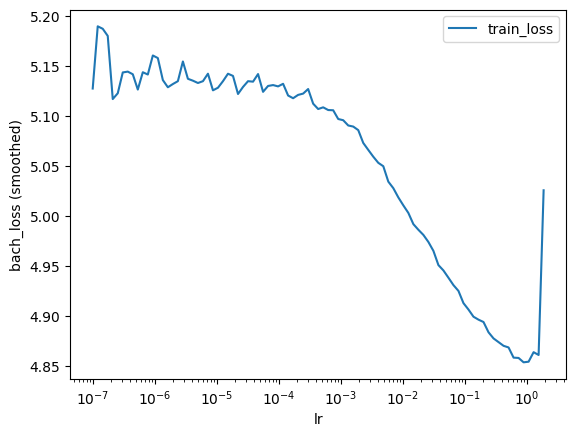

In [133]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [134]:
lrfinder.get_best_lr()

0.08902150854450441

In [22]:
model.optimizer.set_lr(0.01)

In [23]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [24]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.6125,	val_loss: 3.9618
1:	[0s / 0s],		train_loss: 4.5972,	val_loss: 3.9616
2:	[0s / 0s],		train_loss: 4.5814,	val_loss: 3.9619
3:	[0s / 0s],		train_loss: 4.5567,	val_loss: 3.9593
4:	[0s / 0s],		train_loss: 4.5489,	val_loss: 3.9434
5:	[0s / 0s],		train_loss: 4.5598,	val_loss: 3.9411
6:	[0s / 0s],		train_loss: 4.5352,	val_loss: 3.9304
7:	[0s / 0s],		train_loss: 4.5439,	val_loss: 3.9398
8:	[0s / 0s],		train_loss: 4.5371,	val_loss: 3.9396
9:	[0s / 0s],		train_loss: 4.5290,	val_loss: 3.9373
10:	[0s / 0s],		train_loss: 4.5477,	val_loss: 3.9419
11:	[0s / 0s],		train_loss: 4.5370,	val_loss: 3.9262
12:	[0s / 0s],		train_loss: 4.5249,	val_loss: 3.9437
13:	[0s / 0s],		train_loss: 4.5172,	val_loss: 3.9687
14:	[0s / 0s],		train_loss: 4.5297,	val_loss: 3.9393
15:	[0s / 0s],		train_loss: 4.5180,	val_loss: 3.9370
16:	[0s / 0s],		train_loss: 4.4804,	val_loss: 3.9476
17:	[0s / 0s],		train_loss: 4.5244,	val_loss: 3.9193
18:	[0s / 0s],		train_loss: 4.4844,	val_loss: 3.9596
19:

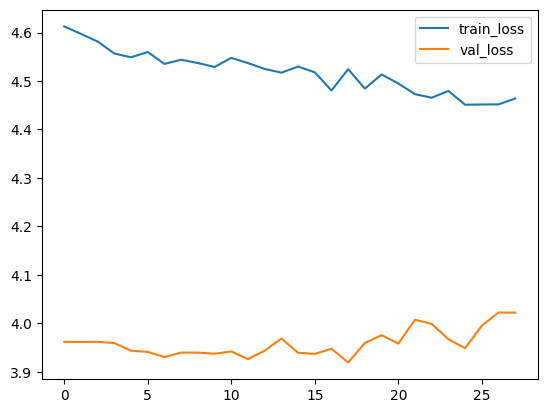

In [25]:
_ = log.plot()

In [18]:
model.partial_log_likelihood(*val).mean()

-4.9723516

In [19]:
_ = model.compute_baseline_hazards()

In [20]:
surv = model.predict_surv_df(x_test)

For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

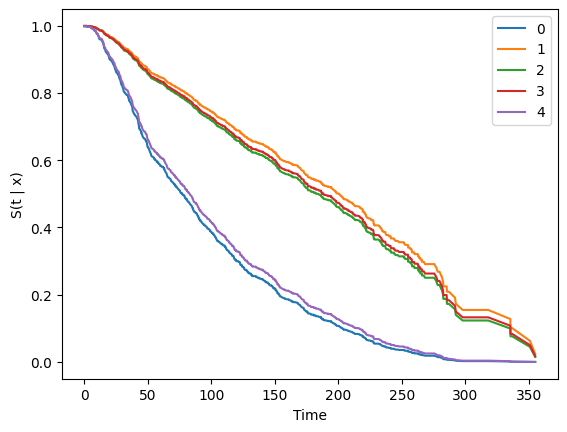

In [21]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. 
Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [28]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

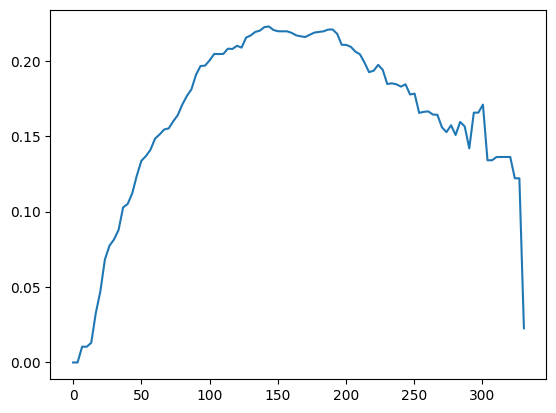

In [23]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [24]:
ev.integrated_brier_score(time_grid)

0.16515071882216267

In [26]:
ev.concordance_td()

0.6539455839972876

In [25]:
ev.integrated_nbll(time_grid)

0.4882641901594463